In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC

pyro.set_rng_seed(123)

from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

/fast/someya/miniforge3/envs/tsunami-NO/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate observation data (synthetic data + some noise)

In [2]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.25, 0.25 # very sparse
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1
lon_mid, lat_mid = (lon_min+lon_max)/2, (lat_min+lat_max)/2


# coordinate transformation
ll2xy = pyproj.Transformer.from_crs(
    crs_from="EPSG:4326", # WGS84
    crs_to=f"+proj=tmerc +lon_0={lon_mid} +lat_0={lat_mid} +ellps=WGS84 +datum=WGS84 +units=km", 
    always_xy=True
)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x_obs, y_obs = ll2xy.transform(Lon, Lat)
X_obs = torch.from_numpy(x_obs)
Y_obs = torch.from_numpy(y_obs)

coords = {
    "x": X_obs,
    "y": Y_obs
}


# source parameters
lat_ref = 40.2224
lon_ref = 144.8678
x_ref, y_ref = ll2xy.transform(lon_ref, lat_ref)

print(x_ref, y_ref) # km

params_true = {
    "x_ref": torch.tensor(x_ref),
    "y_ref": torch.tensor(y_ref),
    "depth": torch.tensor(0.1), # km
    "length": torch.tensor(218.0), # km
    "width": torch.tensor(46.0), # km
    "strike": torch.tensor(189.0), # degree
    "dip": torch.tensor(60.0), # degree
    "rake": torch.tensor(270.0), # degree
    "slip": torch.tensor(5.62) # m
}

ux_obs, uy_obs, uz_obs = okada.compute(coords, params_true, compute_strain=False, is_degree=True) 

-11.25235992480785 24.70296061567198


In [3]:
rng = np.random.default_rng(seed=123)
err = 0.05 * rng.standard_normal((nlon, nlat, 3))

ux_obs += err[:, :, 0]
uy_obs += err[:, :, 1]
uz_obs += err[:, :, 2]

/tmp/ipykernel_1773797/3372770884.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ux_obs += err[:, :, 0]
/tmp/ipykernel_1773797/3372770884.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uy_obs += err[:, :, 1]
/tmp/ipykernel_1773797/3372770884.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uz_obs += err[:, :, 2]


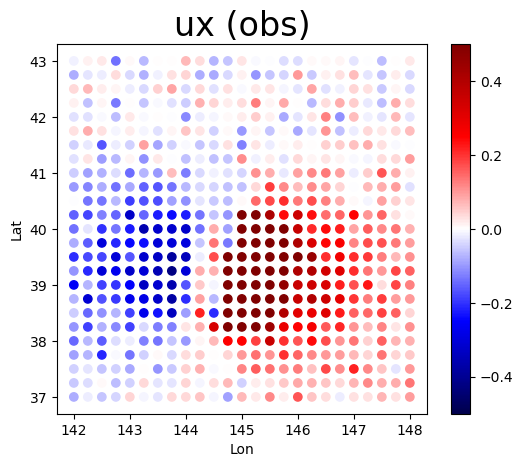

In [4]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=ux_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ux (obs)", fontsize=24)
fig.colorbar(im)
fig.show()

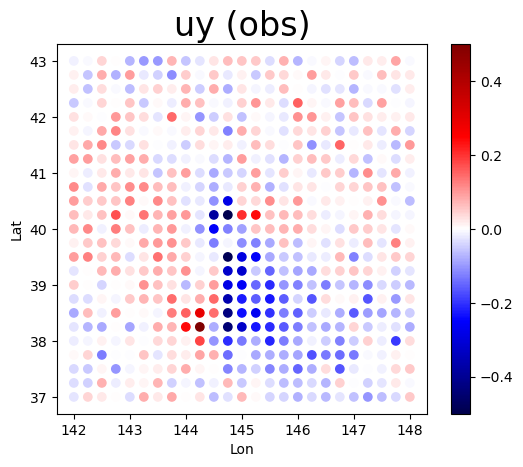

In [5]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uy_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uy (obs)", fontsize=24)
fig.colorbar(im)
fig.show()

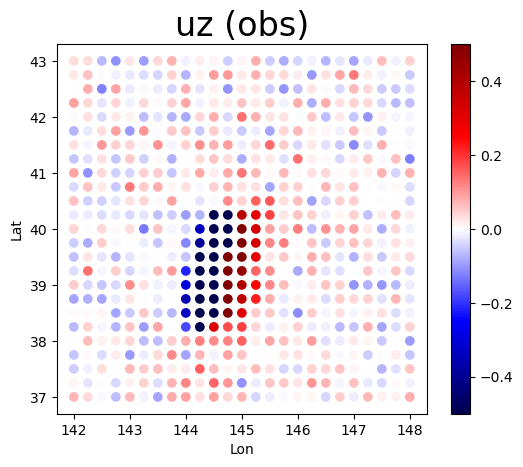

In [6]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uz_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uz (obs)", fontsize=24)
fig.colorbar(im)
fig.show()

# Estimate `slip` using HMC

In [7]:
u_obs = torch.stack([ux_obs, uy_obs, uz_obs])

In [8]:
# define model
def model():
    # prior
    p = pyro.sample("slip", dist.Uniform(torch.tensor([0.0]), torch.tensor([10.0])))

    coords = {
        "x": X_obs,
        "y": Y_obs,
    }

    params = {
        "x_ref": torch.tensor(x_ref),
        "y_ref": torch.tensor(y_ref),
        "depth": torch.tensor(0.1), # km
        "length": torch.tensor(218.0), # km
        "width": torch.tensor(46.0), # km
        "strike": torch.tensor(189.0), # degree
        "dip": torch.tensor(60.0), # degree
        "rake": torch.tensor(270.0), # degree
        "slip": p
    }
    

    # model prediction
    ux_pred, uy_pred, uz_pred = okada.compute(coords, params, compute_strain=False, is_degree=True)
    u_pred = torch.stack([ux_pred, uy_pred, uz_pred])

    # noise distribution 
    pyro.sample("obs", dist.Normal(u_pred, 0.05), obs=u_obs)

In [9]:
hmc_kernel = HMC(model, step_size=0.01, num_steps=100)
mcmc = MCMC(hmc_kernel, num_samples=10000, warmup_steps=200)

In [10]:
# execute MCMC
mcmc.run()
mcmc.summary()

Sample: 100%|██████████| 10200/10200 [02:06, 80.37it/s, step size=7.19e-01, acc. prob=0.912] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   slip[0]      5.61      0.02      5.61      5.57      5.65   3972.71      1.00

Number of divergences: 0


In [11]:
# result
posterior_samples = mcmc.get_samples()
print("estimated parameter (mean):", posterior_samples["slip"].mean(0).item())
print("std:", posterior_samples["slip"].std(0).item())

estimated parameter (mean): 5.61042421173051
std: 0.023431045872092836


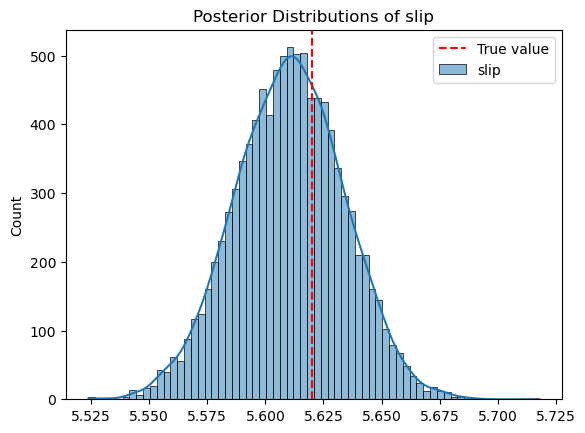

In [12]:
import seaborn as sns

sns.histplot(posterior_samples["slip"][:, 0].numpy(), kde=True, label="slip")
plt.axvline(params_true["slip"].item(), color='red', linestyle='--', label='True value')
plt.legend()
plt.title("Posterior Distributions of slip")
plt.show()